In [168]:
from datetime import datetime
from collections import Counter
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt


# Retrieving the 500 issues

In [172]:
url = 'https://api.github.com/search/issues'
params = {
    'q': 'repo:rails/rails is:issue',
    'per_page': 100 
}

issues = []

while len(issues) < 500:
    response = requests.get(url, params=params)
    response.raise_for_status()
    issues.extend(response.json()['items'])
    params['page'] = params.get('page', 1) + 1
    if response.links.get('next') is None:
        break
print(f"Number of issues fetched: {len(issues)}")

Number of issues fetched: 500


# Creating a data frame with required data

In [232]:
data = []
for issue in issues:
    title = issue['title']
    description = issue['body']
    labels = [label['name'] for label in issue['labels']]
    poster = issue['user']['login']
    date = issue["created_at"]
    data.append({"Title": title, "Description": description, "Labels": labels, "Poster": poster, "Date": date})
df = pd.DataFrame(data)
df.head()

,Title,Description,Labels,Poster,Date
0,Default docker setup is not resilient to host ...,### Steps to reproduce\r\n1. Generate new rail...,[],K4sku,2024-02-21T15:33:23Z
1,find_or_create_by! behavior raises RecordNotFo...,### Steps to reproduce\r\n<!-- (Guidelines for...,[],tubaxenor,2024-02-21T02:02:22Z
2,url_for helper incorrectly combines query para...,### Steps to reproduce\r\n\r\nDefine a route w...,[],DanielHeath,2024-02-20T22:24:40Z
3,"Setter sometimes doesn't update the changes, a...",### Steps to reproduce\r\n\r\nHere is an issue...,[],GeoffreyOnRails,2024-02-20T18:56:52Z
4,Array primary keys (e.g. composite) break `col...,### Steps to reproduce\r\n\r\n```ruby\r\n# fro...,[activerecord],Slotos,2024-02-19T18:36:55Z


# Number of issue posts per month

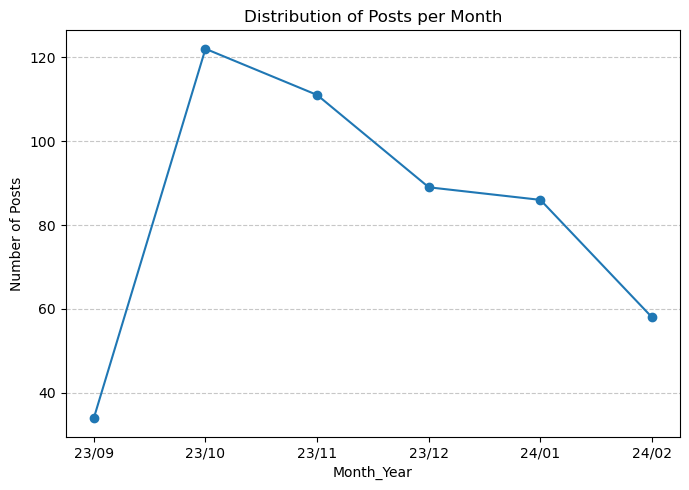

In [233]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month_Year'] = df['Date'].dt.strftime('%y/%m')

posts_per_month = df.groupby('Month_Year').size()
plt.figure(figsize=(7, 5))
posts_per_month.plot(kind='line', marker='o')
plt.title('Distribution of Posts per Month')
plt.xlabel('Month_Year')
plt.ylabel('Number of Posts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Number of issue posts per Weekday

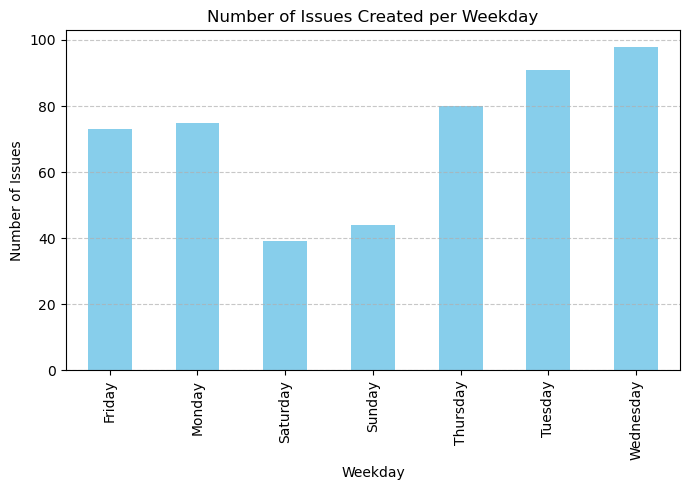

In [234]:
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.day_name()
issues_per_weekday = df.groupby('Weekday').size()

issues_per_weekday.plot(kind='bar', color='skyblue', figsize=(7, 5))
plt.title('Number of Issues Created per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Issues')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Top 10 Posters

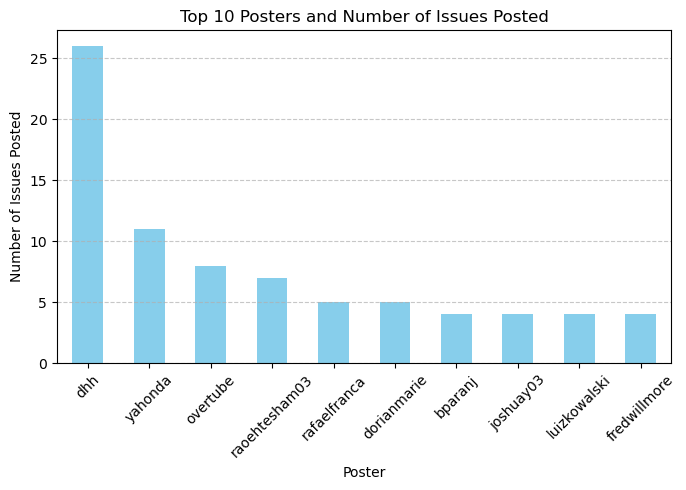

In [236]:
top_posters = df['Poster'].value_counts().head(10)

plt.figure(figsize=(7, 5))
top_posters.plot(kind='bar', color='skyblue')
plt.title('Top 10 Posters and Number of Issues Posted')
plt.xlabel('Poster')
plt.ylabel('Number of Issues Posted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Top 10 Labels 

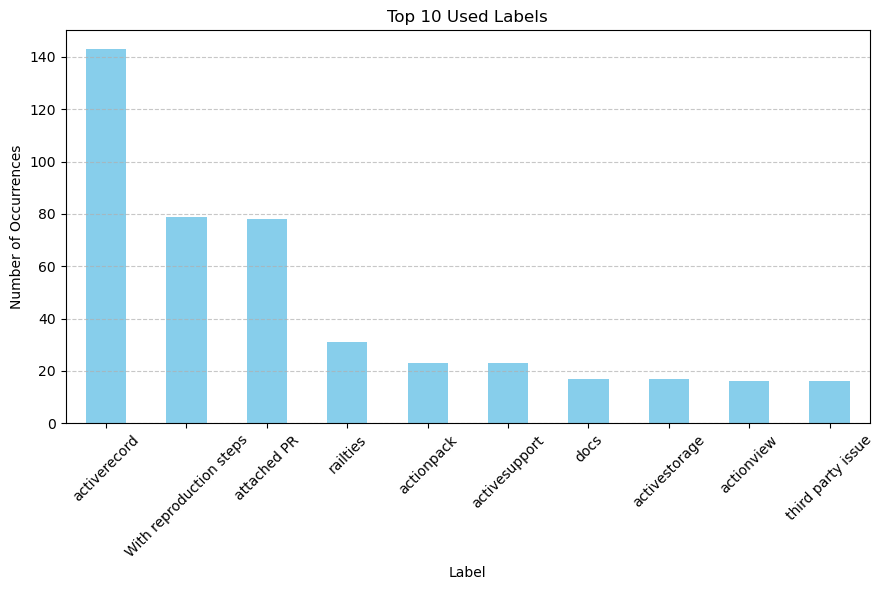

Labels
activerecord               143
With reproduction steps     79
attached PR                 78
railties                    31
actionpack                  23
activesupport               23
docs                        17
activestorage               17
actionview                  16
third party issue           16
Name: count, dtype: int64


In [237]:
top_labels = df['Labels'].explode().value_counts().head(10)

plt.figure(figsize=(9, 6))
top_labels.plot(kind='bar', color='skyblue')
plt.title('Top 10 Used Labels')
plt.xlabel('Label')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(top_labels)

# ML Classifier

In [200]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score, hamming_loss

In [201]:
df = df[['Title', 'Description', 'Labels']]
df.head()

,Title,Description,Labels
0,Default docker setup is not resilient to host ...,### Steps to reproduce\r\n1. Generate new rail...,[]
1,find_or_create_by! behavior raises RecordNotFo...,### Steps to reproduce\r\n<!-- (Guidelines for...,[]
2,url_for helper incorrectly combines query para...,### Steps to reproduce\r\n\r\nDefine a route w...,[]
3,"Setter sometimes doesn't update the changes, a...",### Steps to reproduce\r\n\r\nHere is an issue...,[]
4,Array primary keys (e.g. composite) break `col...,### Steps to reproduce\r\n\r\n```ruby\r\n# fro...,[activerecord]


### Combining Title and description to 1 coulmn

In [202]:
filtered_df = pd.DataFrame({
    'Title_Description': df['Title'] + ';' + df['Description'],
    'Labels': df['Labels']
})
filtered_df.head()

,Title_Description,Labels
0,Default docker setup is not resilient to host ...,[]
1,find_or_create_by! behavior raises RecordNotFo...,[]
2,url_for helper incorrectly combines query para...,[]
3,"Setter sometimes doesn't update the changes, a...",[]
4,Array primary keys (e.g. composite) break `col...,[activerecord]


### Removing issues with no labels

In [203]:
filtered_df = filtered_df[filtered_df['Labels'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
filtered_df.head()

,Title_Description,Labels
0,Array primary keys (e.g. composite) break `col...,[activerecord]
1,Rails 7.1: `ActiveRecord::Base#query_constrain...,"[activerecord, activestorage]"
2,ActionView::Template::Error (undefined method ...,"[activestorage, more-information-needed]"
3,ActionDispatch `recognize_path` trips over dom...,[actionpack]
4,Rails 7.1.* Deserializes Date Range with Infin...,"[activerecord, With reproduction steps]"


In [204]:
type(filtered_df['Labels'].iloc[0])

list

### One-Hot Encoding

In [205]:
multilabel = MultiLabelBinarizer()
y=multilabel.fit_transform(filtered_df['Labels'])

In [206]:
pd.set_option('display.max_columns', None) 
pd.DataFrame(y, columns=multilabel.classes_).head()

,MySQL,PostgreSQL,With reproduction steps,actioncable,actionmailbox,actionmailer,actionpack,actiontext,actionview,activejob,activemodel,activerecord,activestorage,activesupport,asset pipeline,attached PR,ci issues,docs,encryption,engines,good first issue,i18n,more-information-needed,pinned,rails-ujs,railties,regression,routing,stale,third party issue
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [227]:
tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
x = tfidf.fit_transform(filtered_df['Title_Description'])

### Data Splitting

In [208]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### ML Models

In [209]:
sgd = SGDClassifier()
lr = LogisticRegression(dual = False, solver = 'lbfgs')
svc = LinearSVC(dual = True)

### Evaluation Metrics

In [210]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print('Jaccard score: {}'.format(jaccard_score(y_test, y_pred, average='samples')))
    print('Hamming loss: {}'.format(hamming_loss(y_test, y_pred)))
    print("---")

In [229]:
for classifier in [sgd, lr, svc]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Jaccard score: 0.3722222222222222
Hamming loss: 0.04611111111111111
---
Clf:  LogisticRegression
Jaccard score: 0.24722222222222223
Hamming loss: 0.04611111111111111
---
Clf:  LinearSVC
Jaccard score: 0.2944444444444444
Hamming loss: 0.044444444444444446
---
